In [1]:
__imp

Libraries have been loaded


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display

from sklearn import metrics

In [4]:
set_plot_sizes(12,14,16)

### Load Processed Data

In [5]:
basepath = os.path.expanduser('../')

In [6]:
%%time

data = pd.read_hdf(os.path.join(basepath, 'data/interim/dataset1/data.h5'))

# comment it if you don't want to take sample
SAMPLE_SIZE = .3
data = data.loc[data.TARGET.notnull()].sample(frac=SAMPLE_SIZE)

CPU times: user 3.99 s, sys: 1.13 s, total: 5.12 s
Wall time: 5.12 s


In [7]:
print('Shape of the dataset: {}'.format(data.shape))

Shape of the dataset: (92253, 599)


### Modelling

In [8]:
%%time

# replace inf with null values
for col in data.columns: data[col] = data[col].replace([np.inf, -np.inf], np.nan)
df_trn, y_trn, nas = proc_df(data, 'TARGET', skip_flds=['SK_ID_CURR'])

CPU times: user 10.2 s, sys: 1.01 s, total: 11.2 s
Wall time: 11.2 s


In [9]:
def split_vals(X, y, test_size=.3):
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, stratify=y, test_size=test_size, random_state=SEED)
    
    return X_trn, X_val, y_trn, y_val

In [10]:
def print_score(m, X_tr, y_tr, X_val, y_val):
    res = [metrics.log_loss(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.log_loss(y_val, m.predict_proba(X_val)[:, 1]),
           metrics.roc_auc_score(y_tr, m.predict_proba(X_tr)[:, 1]), 
           metrics.roc_auc_score(y_val, m.predict_proba(X_val)[:, 1])]
    
    print(res)

In [11]:
def get_oob(df_keep, y_trn, m=None):
    X_tr, X_val, y_tr, y_val = split_vals(df_keep, y_trn)
    
    if m is None:
        m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
    
    m.fit(X_tr, y_tr)
    print_score(m, X_tr, y_tr, X_val, y_val)
    
    return m

In [13]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [24]:
%%time

m = RandomForestClassifier(n_estimators=40, 
                           min_samples_leaf=5, 
                           max_depth=7,
                           max_features=.2, 
                           n_jobs=-1)

m = get_oob(df_trn, y_trn, m)

[0.23415875482858972, 0.25158956973944996, 0.8026558585688056, 0.7435487093059046]
CPU times: user 1min 53s, sys: 2.45 s, total: 1min 55s
Wall time: 40.8 s


#### Feature Importance

In [25]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
128,EXT_2_3_mean,0.087223
123,EXT_2_3_sum,0.059899
116,EXT_SOURCE_SUM,0.052083
130,weighted_mean_external_scores,0.041066
117,MEAN_EXTERNAL_SCORE,0.036466
118,EXT_3_2,0.032128
38,EXT_SOURCE_3,0.024113
455,ext_2_age,0.018512
288,max_bal_credit_limit,0.013290
216,ratio_debt_credit_sum,0.013097


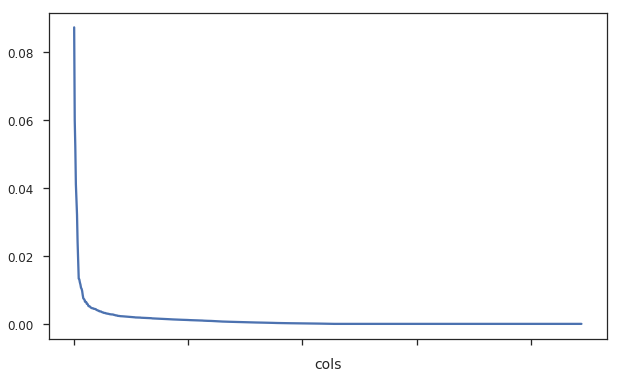

In [26]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

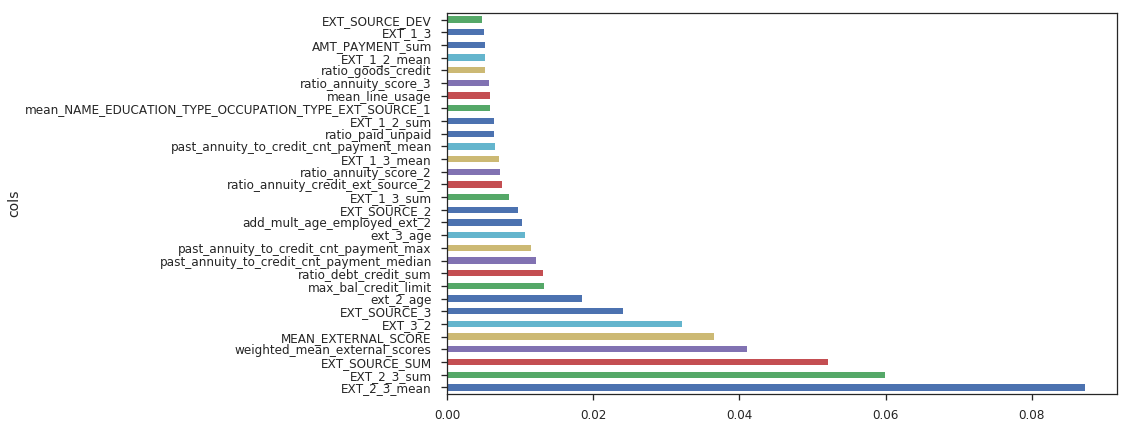

In [27]:
plot_fi(fi[:30]);

In [28]:
to_keep = fi[fi.imp>0.001].cols; len(to_keep)

221

In [29]:
df_keep = df_trn[to_keep].copy()

m = RandomForestClassifier(n_estimators=40, 
                           min_samples_leaf=5, 
                           max_depth=7,
                           max_features=.2, 
                           n_jobs=-1)

m = get_oob(df_keep, y_trn, m)

[0.23469373706707375, 0.25110413887616506, 0.7984931313151644, 0.7448770024676192]


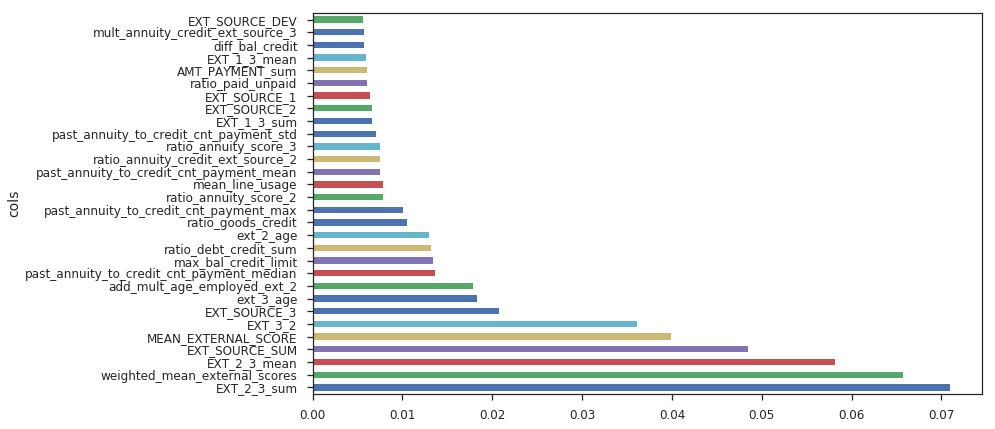

In [30]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30]);

### EDA

Let's look deeply at external scores.

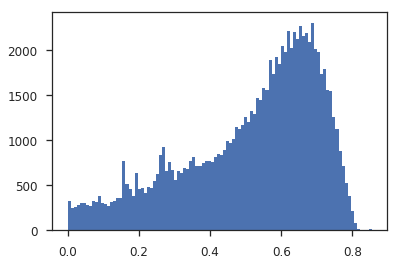

In [14]:
plt.hist(df_trn.EXT_SOURCE_2, bins=100);

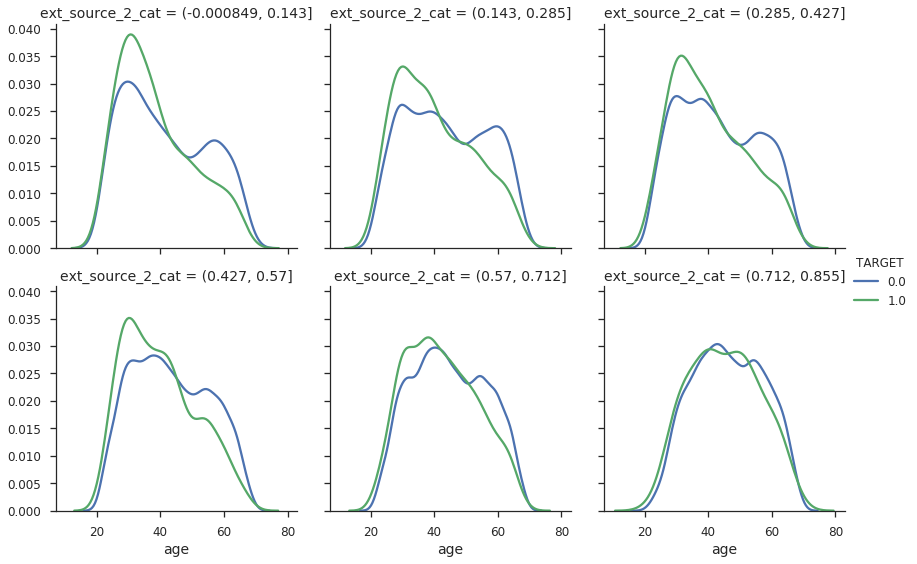

In [16]:
x = df_trn.loc[:, ['EXT_SOURCE_2', 'DAYS_BIRTH']]
x.loc[:, 'TARGET'] = y_trn
x.loc[:, 'ext_source_2_cat'] = pd.cut(x.EXT_SOURCE_2, bins=6)
x.drop('EXT_SOURCE_2', axis=1, inplace=True)

x.loc[:, 'age'] = -x.DAYS_BIRTH / 365
x.drop('DAYS_BIRTH', axis=1, inplace=True)

g = sns.FacetGrid(data=x,
                  col='ext_source_2_cat',
                  hue='TARGET',
                  col_wrap=3,
                  size=4
                 )
g = g.map(sns.kdeplot, 'age').add_legend();

In [18]:
df_trn.loc[:, ['EXT_SOURCE_2', 'EXT_SOURCE_1']].corr()

,EXT_SOURCE_2,EXT_SOURCE_1
EXT_SOURCE_2,1.000000,0.141309
EXT_SOURCE_1,0.141309,1.000000
